In [35]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
import os
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# OPTIONAL: limit NVRAM Usage on GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


In [3]:
# Remove corrupt images
data_dir = 'data'
image_exts = ['jpeg', 'jpg']

for image_class in os.listdir(data_dir):
    
    try:

        for image in os.listdir(os.path.join(data_dir, image_class)):
            
            image_path = os.path.join(data_dir, image_class, image)

            try:
                img = cv2.imread(image_path)
                tip = imghdr.what(image_path)

                if tip not in image_exts:
                    print(f'Image not in ext list {image_path}')
                    os.remove(image_path)

            except Exception as e:
                print(f'Issue with image {image_path}')
                os.remove(image_path)

    except NotADirectoryError:              # Checks wheter dir or .DS_Store
        pass

In [3]:
tf.keras.utils.image_dataset_from_directory??

Signature:
tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    **kwargs,
)
Source:   
@keras_export(
    "keras.utils.image_dataset_from_directory",
    "keras.preprocessing.image_dataset_from_directory",
    v1=[],
)
def image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
    **kwargs,
):
    """Generates a `tf.data.Dataset` from image files in a directory.

    If your directory structure is:



In [25]:
# Load data
data = tf.keras.utils.image_dataset_from_directory(data_dir, image_size=(480, 640))

Found 84 files belonging to 2 classes.


In [26]:
# Inspect data

# Convert data into numpy iterator
data_iterator = data.as_numpy_iterator()

# Convert into batch
batch = data_iterator.next()

# Image 0 represented as numpy array
batch[0].shape

(32, 480, 640, 3)

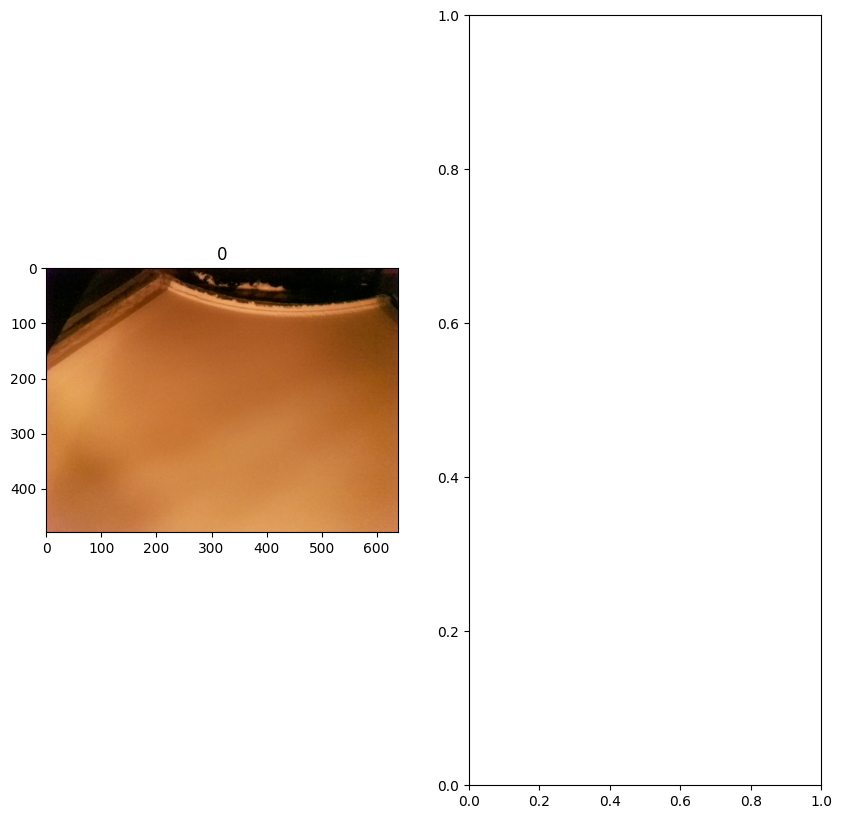

In [27]:
# Get another batch from iterator
batch = data_iterator.next()

# Check integer assigned to class
fig, ax = plt.subplots(ncols=2, figsize= (10, 10))

for idx, img in enumerate(batch[0][:1]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# Class 0 = ok
# Class 2 = overheating

In [16]:
# Preprocess data

# Different options in documentation
# tf.data.Dataset
# .map allows accesing items in pipeline

# Scale data
# data = data.map(lambda x,y: (x/255, y))



In [28]:
# Number of batches
len(data)

3

In [32]:
# Split data
train_size = int(len(data) * 0.8)
test_size = int(len(data) * 0.1)
val_size = int(len(data) * 0.1) + 1

In [33]:
val_size + train_size + test_size

3

In [34]:
# Allocate training/validating/testing sizes
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

In [36]:
# Model architecture
model = Sequential()

model.add(Conv2D(32, (3,3), 1, activation='relu', input_shape=(480, 640, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(64, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(64, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))           # mapping to 0 or 1

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 478, 638, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 239, 319, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 237, 317, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 118, 158, 64)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 116, 156, 64)      36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 58, 78, 64)       0

In [37]:
# Compile model
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [38]:
# Train the model
logdir = 'logs'

# Callback to save tensorboard log to logdir
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [39]:
# Training using model.fit
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
2/2 [==============================] - 4s 1s/step - loss: 2213.5315 - accuracy: 0.5781 - val_loss: 2782.1619 - val_accuracy: 0.3500
Epoch 2/20
2/2 [==============================] - 1s 409ms/step - loss: 1397.1840 - accuracy: 0.3594 - val_loss: 97.7044 - val_accuracy: 0.7000
Epoch 3/20
2/2 [==============================] - 1s 372ms/step - loss: 94.2222 - accuracy: 0.4844 - val_loss: 40.0943 - val_accuracy: 0.6500
Epoch 4/20
2/2 [==============================] - 1s 369ms/step - loss: 22.8693 - accuracy: 0.8125 - val_loss: 41.5159 - val_accuracy: 0.5500
Epoch 5/20
2/2 [==============================] - 1s 372ms/step - loss: 47.7979 - accuracy: 0.5000 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 6/20
2/2 [==============================] - 1s 367ms/step - loss: 0.1293 - accuracy: 1.0000 - val_loss: 2.3823e-05 - val_accuracy: 1.0000
Epoch 7/20
2/2 [==============================] - 1s 380ms/step - loss: 9.7452 - accuracy: 0.8750 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


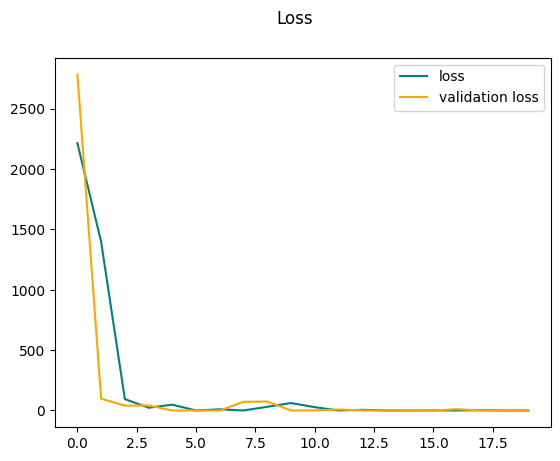

In [43]:
# Plot performance
# hist.history

fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='validation loss')
fig.suptitle('Loss')
plt.legend(loc='upper right')
plt.show()

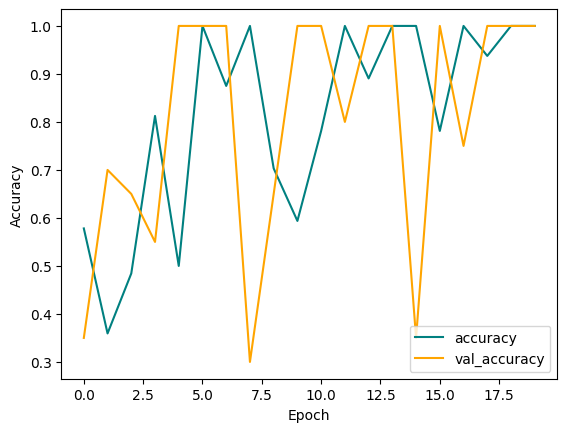

In [50]:
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()